In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd ../data

/content/gdrive/My Drive/11785-project/data


In [ ]:
# !unzip frame.zip

In [ ]:
%cd /content/gdrive/My Drive/11785-project/baseline

/content/gdrive/My Drive/11785-project/baseline


In [ ]:
!python main.py

In [ ]:
import torch 
import numpy as np
from beta_vae import BetaVAE
from detect import Detect
from metric import *
from generate import *
from dataloader import *


In [ ]:
model_state = torch.load('model_state.pkl')

In [ ]:
img_path = '../data/'
csv_name = 'anime_data.csv'
dataset = Dataload(imgpath=img_path, csv_name=csv_name)

In [ ]:
Model = BetaVAE(in_channels=3, latent_dim=1024, hidden_dims=[32, 64, 128, 256, 512], beta=4,
        gamma=1000, max_capacity=25, Capacity_max_iter=1e5, loss_type='H')

def generate_code(model, model_state, dataset, latent_dim):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Device:", device)
    data_loader = data.DataLoader(dataset, batch_size=64, shuffle=False)
    
    latent = []
    model.load_state_dict(model_state)
    model.eval()
    model.cuda()
    print("Start generating the code!!!")
    with torch.no_grad():
        for images in data_loader:
            imgs = images.cuda()
            z = model.generate_latent(imgs) # Tensor[B, latent_dims]
            assert z.shape[1] == latent_dim
            z = np.array(z.cpu())
            for i in range(z.shape[0]):
              latent.append(z[i, :])
    latent = np.array(latent).reshape((-1, latent_dim))
    return latent  # [N, latent_dims]

In [ ]:
def generate_img(model, model_state, img, transform):
    img = transform(img)
    C, H, W = img.shape
    img = img.reshape((1, C, H, W))
    model.load_state_dict(model_state)
    model.cuda()
    model.eval()
    with torch.no_grad():
        img = img.cuda()
        img_re = model.generate_image(img)
    return img_re

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


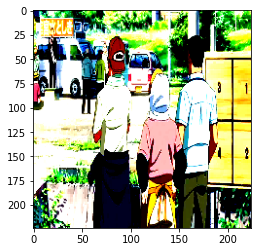

[[[103 110 115]
  [100 107 116]
  [100 104 116]
  ...
  [ 73  74  83]
  [ 70  70  81]
  [ 79  80  89]]

 [[ 99 104 112]
  [101 106 116]
  [104 108 118]
  ...
  [ 70  69  78]
  [ 67  65  71]
  [ 73  73  84]]

 [[105 108 117]
  [109 112 118]
  [109 109 113]
  ...
  [ 72  72  80]
  [ 69  67  77]
  [ 76  76  83]]

 ...

 [[140 131 134]
  [153 152 143]
  [155 148 145]
  ...
  [ 67  65  71]
  [ 66  63  67]
  [ 70  69  78]]

 [[131 136 137]
  [151 147 142]
  [155 146 145]
  ...
  [ 66  63  69]
  [ 66  62  67]
  [ 70  68  75]]

 [[142 133 130]
  [156 152 140]
  [164 154 145]
  ...
  [ 71  70  77]
  [ 69  68  74]
  [ 77  77  83]]]


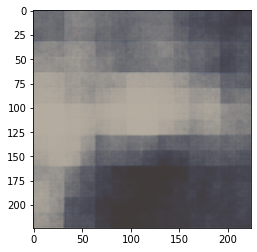

In [ ]:
import matplotlib.pyplot as plt

normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
transform_init = T.Compose([T.ToTensor(), normalize, T.Resize((224, 224))])
path = img_path + np.array(pd.read_csv(csv_name, header=None))
img = Image.open(path[500][0])
img = transform_init(img)
img = img.numpy()
img = np.transpose(img, (1,2,0)) 
plt.imshow(img)
plt.show()
img_re = generate_img(Model, model_state, img, transform_init)
x = img_re[0].cpu()

std= [0.229, 0.224, 0.225]
mean=[0.485, 0.456, 0.406]


x[0]=x[0]*std[0]+mean[0]
x[1]=x[1]*std[1]+mean[1]
x[2]=x[2].mul(std[2])+mean[2]

img = x.mul(255).byte()
img = img.numpy().transpose((1, 2, 0))
# torch.set_num_threads(3)


print(img)
plt.imshow(img)
plt.show()



In [ ]:
latent = generate_code(Model, model_state, dataset, 1024)

Device: cuda
Start generating the code!!!


In [ ]:
def Detect(latent, dis_metric):
    n = latent.shape[0]
    dis_all = []
    for i in range(1, n):
        pre = latent[i-1, :]
        cur = latent[i, :]
        dis =np.linalg.norm(pre-c)
        dis_all.append(dis)
    dis_sorted = np.argsort(dis_all)
    return dis_sorted

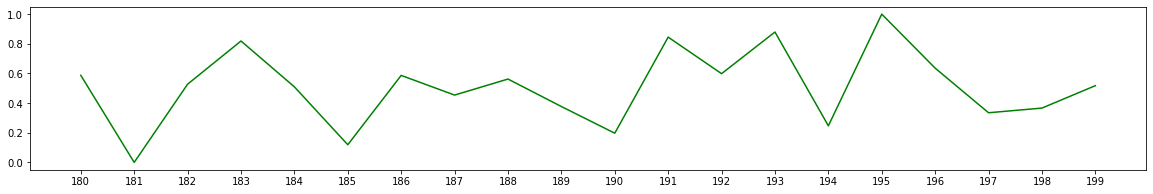

In [ ]:
import scipy.stats
L2 = []
for i in range(180, 200, 1):
    x, y = latent[i, :], latent[i+1, :]
    metric = x.reshape((1, -1)) @ y.reshape((-1, 1)) / (np.linalg.norm(x) * np.linalg.norm(y))
    L2.append(metric.item())

min_L2, max_L2 = 0, 0

min_L2, max_L2 = min(min(L2), min_L2), max(max(L2), max_L2)
normalize = lambda X, mn, mx: [(x - mn)/(mx - mn) for x in X]

L2 = normalize(L2, min_L2, max_L2)

x = np.arange(180, 200, 1)
plt.rcParams["figure.figsize"] = (20,3)

plt.plot(x, L2, 'g')

plt.xticks(range(180, 200, 1))
plt.show()
